# Shor

In [1]:
import cirq
import numpy as np
import cirq_qubitization
import cirq_qubitization.testing as cq_testing
from cirq_qubitization.jupyter_tools import display_gate_and_compilation
from typing import *

## `ModMultiply`
ModMultiply(exponent_bitsize: int, x_bitsize: int, mul_constant: int, mod_N: int)

In [2]:
from cirq_qubitization.shor.mod_multiply import ModMultiply
g = cq_testing.GateHelper(
    ModMultiply(exponent_bitsize=3, x_bitsize=3, mul_constant=123, mod_N=5)
)

display_gate_and_compilation(g)

In [3]:
from cirq_qubitization.atoms import Split, Join
from cirq_qubitization.quantum_graph import LeftDangle, RightDangle, DanglingT

In [4]:
from cirq_qubitization.quantum_graph import ModMultiply
mm = ModMultiply(exponent_bitsize=3, x_bitsize=3, mul_constant=123, mod_N=5)
compbloq = mm.decompose_from_registers()

bbstart {'exponent': <|, 'x': <|} (exponent<5201332784>, x<5201330240>) set()
wire_add Wire(left_gate=<|, left_name='exponent', right_gate=Split(bitsize=3)<0>, right_name='sss')
prev_inst {'x': <|, 'sss0': Split(bitsize=3)<0>, 'sss1': Split(bitsize=3)<0>, 'sss2': Split(bitsize=3)<0>}
wire_add Wire(left_gate=Split(bitsize=3)<0>, left_name='sss2', right_gate=SingleControlModMultiply(x_bitsize=3, mul_constant=1)<1>, right_name='control')
wire_add Wire(left_gate=<|, left_name='x', right_gate=SingleControlModMultiply(x_bitsize=3, mul_constant=1)<1>, right_name='x')
prev_inst {'sss0': Split(bitsize=3)<0>, 'sss1': Split(bitsize=3)<0>, 'control': SingleControlModMultiply(x_bitsize=3, mul_constant=1)<1>, 'x': SingleControlModMultiply(x_bitsize=3, mul_constant=1)<1>}
wire_add Wire(left_gate=Split(bitsize=3)<0>, left_name='sss1', right_gate=SingleControlModMultiply(x_bitsize=3, mul_constant=4)<2>, right_name='control')
wire_add Wire(left_gate=SingleControlModMultiply(x_bitsize=3, mul_constant=1)<

In [5]:
bloqs = set(wire.left_gate for wire in compbloq._wires if not isinstance(wire.left_gate, DanglingT))
bloqs |= set(wire.right_gate for wire in compbloq._wires if not isinstance(wire.right_gate, DanglingT))
bloqs

{SingleControlModMultiply(x_bitsize=3, mul_constant=1)<1>,
 SingleControlModMultiply(x_bitsize=3, mul_constant=3)<3>,
 SingleControlModMultiply(x_bitsize=3, mul_constant=4)<2>,
 Split(bitsize=3)<0>}

In [6]:
compbloq._wires

[Wire(left_gate=<|, left_name='exponent', right_gate=Split(bitsize=3)<0>, right_name='sss'),
 Wire(left_gate=Split(bitsize=3)<0>, left_name='sss2', right_gate=SingleControlModMultiply(x_bitsize=3, mul_constant=1)<1>, right_name='control'),
 Wire(left_gate=<|, left_name='x', right_gate=SingleControlModMultiply(x_bitsize=3, mul_constant=1)<1>, right_name='x'),
 Wire(left_gate=Split(bitsize=3)<0>, left_name='sss1', right_gate=SingleControlModMultiply(x_bitsize=3, mul_constant=4)<2>, right_name='control'),
 Wire(left_gate=SingleControlModMultiply(x_bitsize=3, mul_constant=1)<1>, left_name='x', right_gate=SingleControlModMultiply(x_bitsize=3, mul_constant=4)<2>, right_name='x'),
 Wire(left_gate=Split(bitsize=3)<0>, left_name='sss0', right_gate=SingleControlModMultiply(x_bitsize=3, mul_constant=3)<3>, right_name='control'),
 Wire(left_gate=SingleControlModMultiply(x_bitsize=3, mul_constant=4)<2>, left_name='x', right_gate=SingleControlModMultiply(x_bitsize=3, mul_constant=3)<3>, right_name='

In [7]:
from cirq_qubitization.quantum_graph import GraphDrawer
gd = GraphDrawer(bloqs, compbloq._wires, mm.registers)

In [8]:
print(gd.graphviz().to_string())

digraph qual {
rankdir=LR;
subgraph  {
rank=same;
DanglingT_l_exponent [label=exponent, shape=plaintext];
DanglingT_l_x [label=x, shape=plaintext];
}

Split_0 [label=<<TABLE BORDER="1" CELLBORDER="1" CELLSPACING="3"><tr><td colspan="2">Split_0</td></tr><TR><TD rowspan="3" port="sss">in</TD><TD port="sss0_out">0</TD></TR><TR><TD port="sss1_out">1</TD></TR><TR><TD port="sss2_out">2</TD></TR></TABLE>>, shape=plain];
SingleControlModMultiply_1 [label=<<TABLE BORDER="1" CELLBORDER="1" CELLSPACING="3"><tr><td colspan="2">SingleControlModMultiply_1</td></tr><TR><TD PORT="control">control</TD><TD PORT="control_out">control_out</TD></TR><TR><TD PORT="x">x</TD><TD PORT="x_out">x_out</TD></TR></TABLE>>, shape=plain];
SingleControlModMultiply_2 [label=<<TABLE BORDER="1" CELLBORDER="1" CELLSPACING="3"><tr><td colspan="2">SingleControlModMultiply_2</td></tr><TR><TD PORT="control">control</TD><TD PORT="control_out">control_out</TD></TR><TR><TD PORT="x">x</TD><TD PORT="x_out">x_out</TD></TR></TABLE>>,

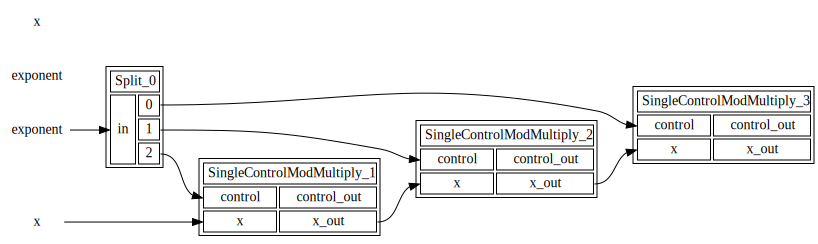

In [9]:
from IPython.display import SVG
SVG(gd.graphviz().create_svg())

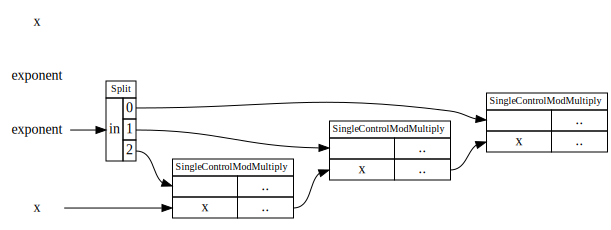

In [10]:
SVG(gd.to_pretty().graphviz().create_svg())

```python
nodes, edges = g.gate.compute_graph()
import networkx as nx
from matplotlib import pyplot as plt

plt.subplots(figsize=(7,7))
gg = nx.from_edgelist(e.tt for e in edges)
rs = np.random.RandomState()
fuzz = lambda: rs.normal(0, 0.05)

pos = {}

for yi, r in enumerate(g.r):
    pos[LeftDangle, r.name] = (-1, 0.2*yi+fuzz())
    pos[RightDangle, r.name] = (len(nodes), 0.2*yi+fuzz())

for xi, gate in enumerate(nodes):
    
    for yi, r in enumerate(gate.registers):
        pos[gate, r.name] = (xi+fuzz(), 0.2*yi+fuzz())
    
    for r1, r2 in zip(gate.registers, gate.registers[1:]):
        gg.add_edge((gate, r1.name), (gate, r2.name), typ='vert')
    
    
#pos = nx.spring_layout(gg, pos=pos, iterations=1)
nx.draw_networkx(gg, pos=pos)
```

In [11]:
import cirq
q0, q1 = cirq.LineQubit.range(2)
circuit = cirq.Circuit(cirq.CNOT(q0, q1), cirq.CNOT(q0, q1))
circuit

0: ───@───@───
      │   │
1: ───X───X───

In [12]:
ops = list(circuit.all_operations())
ops[0] == ops[1]

True

In [13]:
from cirq_qubitization.quantum_graph import _QuantumGraphBuilder, QubitTracer

gate = ModMultiply(exponent_bitsize=3, x_bitsize=3, mul_constant=123, mod_N=5)
g = cq_testing.GateHelper(gate)

gb = _QuantumGraphBuilder()
tracer_qubits = {reg.name: QubitTracer(reg.name, reg.bitsize, graph_builder=gb) for reg in gate.registers}
gb.left_gate = {reg.name: LeftDangle for reg in gate.registers}
op = list(gate.decompose_from_registers(**tracer_qubits))

nodes = gb.nodes
edges = gb.wires

TypeError: ModMultiply.decompose_from_registers() got an unexpected keyword argument 'exponent'

In [ ]:
gate = ModMultiply(exponent_bitsize=3, x_bitsize=3, mul_constant=123, mod_N=5)
nodes, edges = gate.compute_graph()

In [ ]:
from cirq_qubitization.shor.mod_multiply import SingleControlModMultiply
SingleControlModMultiply(3, 123) == SingleControlModMultiply(3, 123)

In [ ]:
from collections import defaultdict
i_by_prefix = defaultdict(lambda: 0)
saved = {}

def gid(gate, regname):
    pot = saved.get((gate, regname), None)
    if pot is not None:
        return pot
    
    gname = gate.__class__.__name__
    i = i_by_prefix[gname, regname]
    i_by_prefix[gname, regname] += 1
    name = f'{gname}_{i}_{regname}'
    saved[gate, regname] = name
    return name

In [ ]:
import networkx
import pydot

graph = pydot.Dot('qual', graph_type='digraph', rankdir='LR')

dang = pydot.Subgraph(rank='same')
for yi, r in enumerate(g.r):
    dang.add_node(pydot.Node(gid(LeftDangle, r.name), label=f'{r.name}', shape='plaintext'))
graph.add_subgraph(dang)
  
for xi, gate in enumerate(nodes):
    if isinstance(gate, Split):
        graph.add_node(pydot.Node(gid(gate, ''), shape='triangle', label='', orientation=90))
        continue
    if isinstance(gate, Join):
        graph.add_node(pydot.Node(gid(gate, ''), shape='triangle', label='', orientation=-90))
        continue
    
    
    ports = [f'<{r.name}>{r.name}' for r in gate.registers]
    label = '<<TABLE BORDER="1" CELLBORDER="0" CeLLSPACING="0">'
    label += f'<tr><td><font point-size="10">{gate.pretty_name()}</font></td></tr>'
    for r in gate.registers:
        if r.name == 'control':
            celllab='\u2b24'
        else:
            celllab=r.name
        
        label += f'<TR><TD PORT="{r.name}">{celllab}</TD></TR>'
    label += '</TABLE>>'
    
    #graph.add_node(pydot.Node(gid(gate, ''), label='|'.join([f'{gate.__class__.__name__}']+ports)))        
    graph.add_node(pydot.Node(gid(gate, ''), label=label, shape='plain'))

dang = pydot.Subgraph(rank='same')
for yi, r in enumerate(g.r):
    dang.add_node(pydot.Node(gid(RightDangle, r.name), label=f'{r.name}', shape='plaintext'))
graph.add_subgraph(dang)

for wire in edges:
    (lg, ln), (rg, rn) = wire.tt
    if isinstance(lg, DanglingT):
        graph.add_edge(pydot.Edge(gid(lg, ln), gid(rg, '')+':'+rn))
    elif isinstance(rg, DanglingT):
        graph.add_edge(pydot.Edge(gid(lg, '')+':'+ln, gid(rg, rn)))
    else:  
        graph.add_edge(pydot.Edge(gid(lg, '')+':'+ln, gid(rg, '')+':'+rn, arrowhead='none'))

from IPython.display import SVG
SVG(graph.create_svg())

In [ ]:
print(graph.to_string())

In [ ]:
import networkx
import pydot

graph = pydot.Dot('qual', graph_type='graph', rankdir='TB')

for wire in edges:
    (lg, ln), (rg, rn) = wire.tt
    graph.add_edge(pydot.Edge(gid(lg, ln), gid(rg, rn)))


dang = pydot.Subgraph(rank='same')
for yi, r in enumerate(g.r):
    dang.add_node(pydot.Node(gid(LeftDangle, r.name), label=f'{LeftDangle}\n{r.name}'))
    #graph.add_node(pydot.Node(gid(RightDangle, r.name), label=f'{RightDangle}\n{r.name}'))
graph.add_subgraph(dang)

    
for xi, gate in enumerate(nodes):    
    
    clu = pydot.Cluster(graph_name=gid(gate, 'cluster'), label=f'{gate.__class__.__name__}')
    #clu = pydot.Subgraph()
    
    for yi, r in enumerate(gate.registers):
        print(gate, r)
        clu.add_node(pydot.Node(gid(gate, r.name), label=f'{r.name}'))
        
    for r1, r2 in zip(gate.registers, gate.registers[1:]):
        clu.add_edge(pydot.Edge(gid(gate, r1.name), gid(gate, r2.name), color='red', constraint=False))
    
    #clu0.add_subgraph(clu)
    graph.add_subgraph(clu)



dang = pydot.Subgraph(rank='same')
for yi, r in enumerate(g.r):
    #graph.add_node(pydot.Node(gid(LeftDangle, r.name), label=f'{LeftDangle}\n{r.name}'))
    dang.add_node(pydot.Node(gid(RightDangle, r.name), label=f'{RightDangle}\n{r.name}'))
graph.add_subgraph(dang)



from IPython.display import SVG
SVG(graph.create_svg())

In [ ]:
print(graph.to_string())

In [ ]:
print(graph.create_dot().decode())

In [ ]:
n = graph.get_node_list()[0] 
n.get_name()

In [ ]:
import graphviz
>>> dot = graphviz.Digraph(comment='The Round Table')
>>> dot.node('A', 'King Arthur')  # doctest: +NO_EXE
>>> dot.node('B', 'Sir Bedevere the Wise')
>>> dot.node('L', 'Sir Lancelot the Brave')

>>> dot.edges(['AB', 'AL'])
>>> dot.edge('B', 'L', constraint='false')

In [ ]:
nodes

In [ ]:
nodes[0].registers

In [ ]:
list(gg.nodes)

## `SingleControlModMultiply`
SingleControlModMultiply(x_bitsize: int, mul_constant: int)

In [ ]:
from cirq_qubitization.shor.mod_multiply import SingleControlModMultiply
g = cq_testing.GateHelper(
    SingleControlModMultiply(x_bitsize=3, mul_constant=123)
)

display_gate_and_compilation(g)